# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # キルとデスの差
    df['killDeathDiff'] = df['blueKills'] - df['blueDeaths']
    # 負の値を0で置き換え
    df['killDeathDiff'] = df['killDeathDiff'].clip(lower=0)

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # ゴールドと経験値の相互作用
    df['goldXexperience'] = df['blueTotalGold'] * df['blueTotalExperience']

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # 効率的なリソース利用
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1

    # エリートモンスターの討伐効率
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

# 特徴量の効き

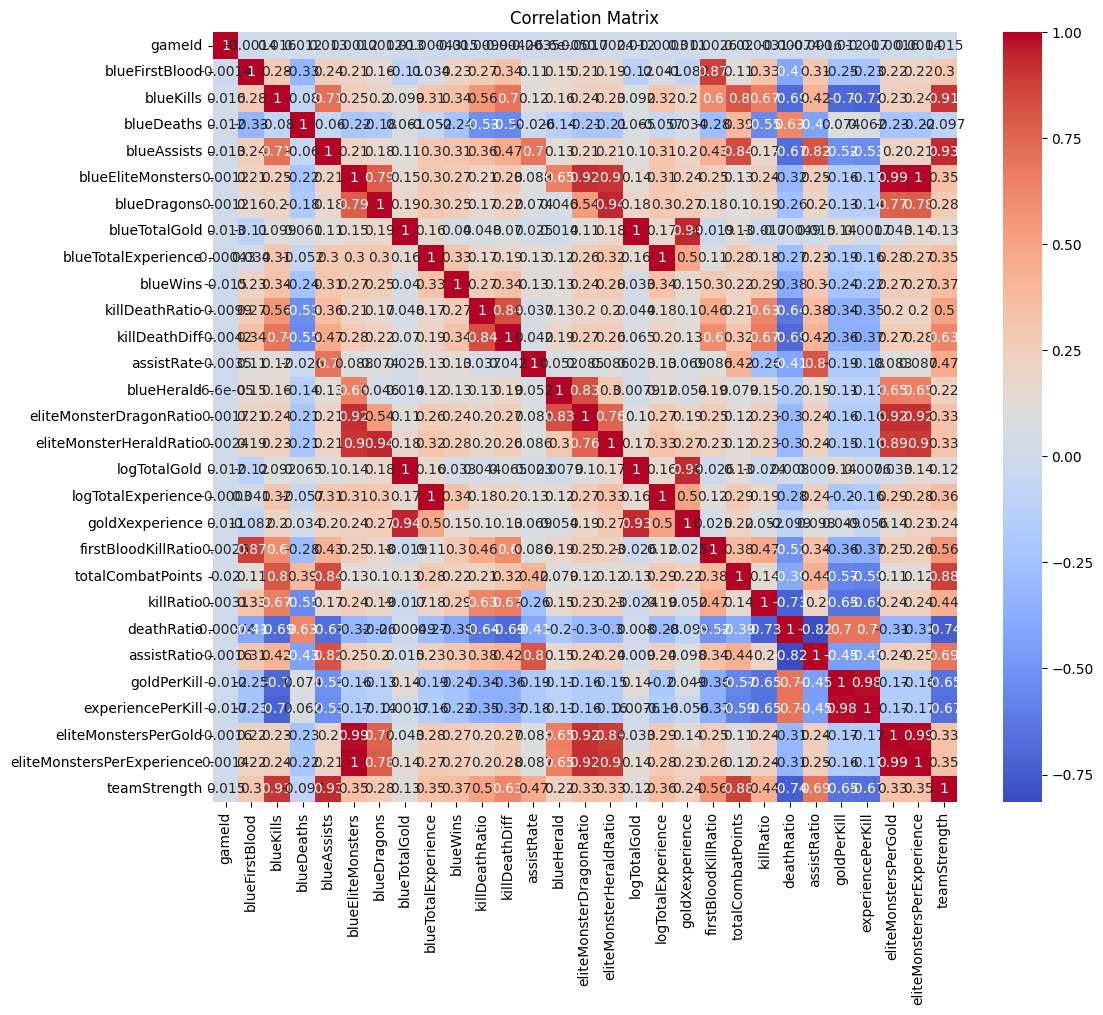

In [7]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- data

In [8]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

- LightGBM

- optuna

In [9]:
# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',  # 最適化する評価指標を指定
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 10),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

- study

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
lgb_model = lgb.LGBMClassifier(**best_params)
lgb_model.fit(X_train, y_train)

# 特徴量選択を行う前に、全特徴量でモデルをトレーニング
best_params = study.best_params
lgb_model_full = lgb.LGBMClassifier(**best_params)
lgb_model_full.fit(X_train, y_train)

# 重要度が閾値以上の特徴量を選択
selector = SelectFromModel(lgb_model_full, threshold='median')
selector.fit(X_train, y_train)

# 選択された特徴量でデータセットを変換
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
test_drop_gameId_selected = selector.transform(test_drop_gameId)

# 選択された特徴量を使ってモデルを再学習
lgb_model_selected = lgb.LGBMClassifier(**best_params)
lgb_model_selected.fit(X_train_selected, y_train)

# バリデーションデータでの評価（選択された特徴量を使用）
y_val_pred_selected = lgb_model_selected.predict(X_val_selected)
accuracy_selected = accuracy_score(y_val, y_val_pred_selected)
print(f"Validation Accuracy with selected features: {accuracy_selected}")

# テストデータでの予測（選択された特徴量を使用）
y_test_pred_selected = lgb_model_selected.predict(test_drop_gameId_selected)

# 予測結果の表示
print(y_test_pred_selected)


[I 2024-01-19 15:37:43,459] A new study created in memory with name: no-name-0af53f96-44ce-48a6-be5d-f6cb237ee4db
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:37:43,936] Trial 0 finished with value: 0.795 and parameters: {'lambda_l1': 1.0928258691066564, 'lambda_l2': 0.00017099648562736216, 'num_leaves': 50, 'feature_fraction': 0.5419363223674695, 'bagging_fraction': 0.9141830100266297, 'bagging_freq': 1, 'min_child_samples': 77, 'learning_rate': 0.0030926409563727963, 'min_split_gain': 6.430190644595556e-06, 'min_child_weight': 1.9587621034288818, 'max_depth': 41, 'n_estimators': 188}. Best is trial 0 with value: 0.795.


Did not meet early stopping. Best iteration is:
[188]	valid_0's binary_logloss: 0.549832
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[165]	valid_0's binary_logloss: 0.69308


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.690934
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:37:44,446] Trial 3 finished with value: 0.778125 and parameters: {'lambda_l1': 2.5843537302097808, 'lambda_l2': 0.004213139088294414, 'num_leaves': 224, 'feature_fraction': 0.5984517036379311, 'bagging_fraction': 0.4455360955898633, 'bagging_freq': 6, 'min_child_samples': 59, 'learning_rate': 0.0016993870913080593, 'min_split_gain': 0.0915756204087975, 'min_child_weight': 7.691420767107014, 'max_depth': 22, 'n_estimators': 251}. Best is trial 0 with value: 0.795.
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

Did not meet early stopping. Best iteration is:
[251]	valid_0's binary_logloss: 0.581687
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's binary_logloss: 0.61124
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[179]	valid_0's binary_logloss: 0.691478
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.692544
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.445686
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's binary_logloss: 0.693063


[I 2024-01-19 15:37:46,651] Trial 8 finished with value: 0.50625 and parameters: {'lambda_l1': 0.009209890795802008, 'lambda_l2': 1.396074361802834e-06, 'num_leaves': 201, 'feature_fraction': 0.8902544242752342, 'bagging_fraction': 0.945031590376283, 'bagging_freq': 4, 'min_child_samples': 9, 'learning_rate': 1.4575975764729376e-07, 'min_split_gain': 0.00017521969965535023, 'min_child_weight': 0.004273602356756049, 'max_depth': 22, 'n_estimators': 294}. Best is trial 0 with value: 0.795.
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:37:47,206] Trial 9 finished with value: 0.50625 and parameters: {'lambda_l1': 0.008908225650090631, 'lambda_l2': 1.8349759403828747e-06, 'num_leaves': 115, 'feature_fraction': 0.9168501571466493, 'bagging_fraction': 0.7667527053858227, 'bagging_freq': 2, 'min_child_samples': 70, 'learning_rate': 3.4450678887629015e-07, 'min_split_gain': 2.031435417348017e-07, 'min_child_weight': 1.3452435148332067, 'max_depth': 39, 'n_estimators': 294}. Best is trial 0 with value: 0.795.


Did not meet early stopping. Best iteration is:
[294]	valid_0's binary_logloss: 0.693041


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.436442
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.443848


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.434683
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.438835


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.436139


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[115]	valid_0's binary_logloss: 0.529425
Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:37:48,517] Trial 16 finished with value: 0.798125 and parameters: {'lambda_l1': 1.0837159487549118e-08, 'lambda_l2': 3.239546711649599e-07, 'num_leaves': 148, 'feature_fraction': 0.48945446709913704, 'bagging_fraction': 0.9989216763556297, 'bagging_freq': 7, 'min_child_samples': 84, 'learning_rate': 0.04948323901608615, 'min_split_gain': 8.642657093574836e-08, 'min_child_weight': 0.033240056924206896, 'max_depth': 14, 'n_estimators': 141}. Best is trial 14 with value: 0.799375.


Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.434238
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.437479
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[237]	valid_0's binary_logloss: 0.634907
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[145]	valid_0's binary_logloss: 0.462106
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[160]	valid_0's binary_logloss: 0.443784
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.458211
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[157]	valid_0's binary_logloss: 0.463868
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[153]	valid_0's binary_logloss: 0.466591
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[223]	valid_0's binary_logloss: 0.665357
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[211]	valid_0's binary_logloss: 0.473654
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[168]	valid_0's binary_logloss: 0.662629
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.463382
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[148]	valid_0's binary_logloss: 0.613124
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[198]	valid_0's binary_logloss: 0.526926
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.441261


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:37:54,851] Trial 31 finished with value: 0.80375 and parameters: {'lambda_l1': 3.3553065846895e-06, 'lambda_l2': 1.837512356386821e-07, 'num_leaves': 98, 'feature_fraction': 0.5681945607588043, 'bagging_fraction': 0.6341452227150869, 'bagging_freq': 5, 'min_child_samples': 68, 'learning_rate': 0.018817375858076208, 'min_split_gain': 3.3065988208392396e-06, 'min_child_weight': 1.3092608160471548, 'max_depth': 20, 'n_estimators': 152}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[152]	valid_0's binary_logloss: 0.444444
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[168]	valid_0's binary_logloss: 0.439332
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.441223


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:37:55,793] Trial 34 finished with value: 0.794375 and parameters: {'lambda_l1': 1.8107763296684996e-07, 'lambda_l2': 3.2014009566120267e-06, 'num_leaves': 94, 'feature_fraction': 0.6250270634181472, 'bagging_fraction': 0.6737696388573804, 'bagging_freq': 5, 'min_child_samples': 77, 'learning_rate': 0.009064463286306178, 'min_split_gain': 4.2720834634405876e-07, 'min_child_weight': 3.1772756520062573, 'max_depth': 28, 'n_estimators': 129}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[129]	valid_0's binary_logloss: 0.490863
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[159]	valid_0's binary_logloss: 0.59416
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[87]	valid_0's binary_logloss: 0.438427
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[180]	valid_0's binary_logloss: 0.495367
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[139]	valid_0's binary_logloss: 0.44197
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[77]	valid_0's binary_logloss: 0.687425
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[160]	valid_0's binary_logloss: 0.632774
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[148]	valid_0's binary_logloss: 0.534612
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[148]	valid_0's binary_logloss: 0.452479
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[170]	valid_0's binary_logloss: 0.562921
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.443796
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[131]	valid_0's binary_logloss: 0.637464
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[113]	valid_0's binary_logloss: 0.494105
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.465431
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[266]	valid_0's binary_logloss: 0.536109
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.438799
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[151]	valid_0's binary_logloss: 0.689735
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[139]	valid_0's binary_logloss: 0.442348
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[120]	valid_0's binary_logloss: 0.437558
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[138]	valid_0's binary_logloss: 0.465523


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[159]	valid_0's binary_logloss: 0.485095


[I 2024-01-19 15:38:02,465] Trial 54 finished with value: 0.79625 and parameters: {'lambda_l1': 2.0088804379406034e-06, 'lambda_l2': 1.2715289032465357e-06, 'num_leaves': 238, 'feature_fraction': 0.5848004989681403, 'bagging_fraction': 0.6439339918414226, 'bagging_freq': 6, 'min_child_samples': 71, 'learning_rate': 0.007824100155421327, 'min_split_gain': 5.171064546788993e-07, 'min_child_weight': 0.3030506031487902, 'max_depth': 11, 'n_estimators': 159}. Best is trial 20 with value: 0.808125.
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.440833


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.444987
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.su

Did not meet early stopping. Best iteration is:
[105]	valid_0's binary_logloss: 0.448682
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[194]	valid_0's binary_logloss: 0.496542
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[192]	valid_0's binary_logloss: 0.505203
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[236]	valid_0's binary_logloss: 0.609555
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[164]	valid_0's binary_logloss: 0.444885


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.448335


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[152]	valid_0's binary_logloss: 0.509013


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:06,705] Trial 64 finished with value: 0.7975 and parameters: {'lambda_l1': 9.047491900664045e-07, 'lambda_l2': 7.984867660630118e-07, 'num_leaves': 145, 'feature_fraction': 0.6385077859844214, 'bagging_fraction': 0.62941141361304, 'bagging_freq': 5, 'min_child_samples': 17, 'learning_rate': 0.03747072109072008, 'min_split_gain': 1.925617377247613e-05, 'min_child_weight': 0.5816903101153658, 'max_depth': 14, 'n_estimators': 143}. Best is trial 20 with value: 0.808125.


Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.442895
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[185]	valid_0's binary_logloss: 0.551383
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[186]	valid_0's binary_logloss: 0.574335
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[186]	valid_0's binary_logloss: 0.563138
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[217]	valid_0's binary_logloss: 0.639961
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[186]	valid_0's binary_logloss: 0.529088
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[176]	valid_0's binary_logloss: 0.572375
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[178]	valid_0's binary_logloss: 0.582642
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[201]	valid_0's binary_logloss: 0.575956


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:12,073] Trial 73 finished with value: 0.78875 and parameters: {'lambda_l1': 0.00011053245936012302, 'lambda_l2': 2.034008071939393e-08, 'num_leaves': 234, 'feature_fraction': 0.4472426911051515, 'bagging_fraction': 0.7255573852728245, 'bagging_freq': 7, 'min_child_samples': 30, 'learning_rate': 0.0005129830367524403, 'min_split_gain': 2.2001061077208383e-07, 'min_child_weight': 2.937385570157005, 'max_depth': 26, 'n_estimators': 178}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[178]	valid_0's binary_logloss: 0.659306
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[175]	valid_0's binary_logloss: 0.56729
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[187]	valid_0's binary_logloss: 0.602022


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:13,788] Trial 76 finished with value: 0.759375 and parameters: {'lambda_l1': 7.791258615784325e-05, 'lambda_l2': 1.3622356383390511e-06, 'num_leaves': 219, 'feature_fraction': 0.47068894890294094, 'bagging_fraction': 0.7717252057984385, 'bagging_freq': 6, 'min_child_samples': 48, 'learning_rate': 0.0003312744250967496, 'min_split_gain': 3.7397675626673654e-08, 'min_child_weight': 1.0653985139075264, 'max_depth': 32, 'n_estimators': 163}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[163]	valid_0's binary_logloss: 0.67267
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[181]	valid_0's binary_logloss: 0.465914
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[223]	valid_0's binary_logloss: 0.541933


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:15,776] Trial 79 finished with value: 0.799375 and parameters: {'lambda_l1': 0.0003298753821072334, 'lambda_l2': 3.2990312122799697e-07, 'num_leaves': 234, 'feature_fraction': 0.5423107016054992, 'bagging_fraction': 0.7350810529802925, 'bagging_freq': 7, 'min_child_samples': 40, 'learning_rate': 0.0008661498914703785, 'min_split_gain': 7.156842116484151e-07, 'min_child_weight': 2.2922518271676573, 'max_depth': 26, 'n_estimators': 168}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[168]	valid_0's binary_logloss: 0.641413


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:16,590] Trial 80 finished with value: 0.803125 and parameters: {'lambda_l1': 6.771036364754736e-05, 'lambda_l2': 7.13276202721997e-08, 'num_leaves': 256, 'feature_fraction': 0.47517598123310245, 'bagging_fraction': 0.715816683991643, 'bagging_freq': 7, 'min_child_samples': 23, 'learning_rate': 0.001648050095895722, 'min_split_gain': 9.098820049597499e-08, 'min_child_weight': 0.7053467382668863, 'max_depth': 21, 'n_estimators': 201}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[201]	valid_0's binary_logloss: 0.590878


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:17,153] Trial 81 finished with value: 0.80625 and parameters: {'lambda_l1': 3.339683366123355e-05, 'lambda_l2': 3.3912229616073837e-07, 'num_leaves': 207, 'feature_fraction': 0.4876264652526124, 'bagging_fraction': 0.7598735260324545, 'bagging_freq': 7, 'min_child_samples': 35, 'learning_rate': 0.0020463170928156664, 'min_split_gain': 7.536978073908507e-08, 'min_child_weight': 4.099466152495113, 'max_depth': 24, 'n_estimators': 191}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[191]	valid_0's binary_logloss: 0.578944


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:17,890] Trial 82 finished with value: 0.805 and parameters: {'lambda_l1': 1.8889002880841837e-05, 'lambda_l2': 2.670990153039358e-06, 'num_leaves': 196, 'feature_fraction': 0.524543887564801, 'bagging_fraction': 0.756942901056008, 'bagging_freq': 7, 'min_child_samples': 28, 'learning_rate': 0.0034233610708758297, 'min_split_gain': 1.6500319970354437e-08, 'min_child_weight': 6.826166567852554, 'max_depth': 24, 'n_estimators': 192}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[192]	valid_0's binary_logloss: 0.532096


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:18,503] Trial 83 finished with value: 0.80625 and parameters: {'lambda_l1': 5.158121096860502e-06, 'lambda_l2': 3.534680489579652e-06, 'num_leaves': 177, 'feature_fraction': 0.4602715107965347, 'bagging_fraction': 0.7578026645940457, 'bagging_freq': 6, 'min_child_samples': 27, 'learning_rate': 0.007717816921606318, 'min_split_gain': 1.3297229949092177e-08, 'min_child_weight': 1.4531916857463179, 'max_depth': 24, 'n_estimators': 176}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[176]	valid_0's binary_logloss: 0.470745


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:19,127] Trial 84 finished with value: 0.805 and parameters: {'lambda_l1': 6.245547042724889e-06, 'lambda_l2': 3.4962604994546177e-06, 'num_leaves': 180, 'feature_fraction': 0.4595504622188028, 'bagging_fraction': 0.7900688779515153, 'bagging_freq': 6, 'min_child_samples': 28, 'learning_rate': 0.006430674989499771, 'min_split_gain': 1.9059035422002647e-08, 'min_child_weight': 7.348639529937842, 'max_depth': 24, 'n_estimators': 191}. Best is trial 20 with value: 0.808125.


Did not meet early stopping. Best iteration is:
[191]	valid_0's binary_logloss: 0.478469


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:19,721] Trial 85 finished with value: 0.809375 and parameters: {'lambda_l1': 2.4072744415266265e-05, 'lambda_l2': 1.1739240917052493e-06, 'num_leaves': 193, 'feature_fraction': 0.5550414295396718, 'bagging_fraction': 0.7590533827087117, 'bagging_freq': 7, 'min_child_samples': 32, 'learning_rate': 0.004042208566074764, 'min_split_gain': 3.049497839448021e-08, 'min_child_weight': 1.5000461886829466, 'max_depth': 19, 'n_estimators': 175}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[175]	valid_0's binary_logloss: 0.525119


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:20,366] Trial 86 finished with value: 0.80625 and parameters: {'lambda_l1': 8.397702379943892e-06, 'lambda_l2': 1.0407661079157166e-06, 'num_leaves': 172, 'feature_fraction': 0.5514851266461379, 'bagging_fraction': 0.761143850869565, 'bagging_freq': 6, 'min_child_samples': 32, 'learning_rate': 0.00932747530864512, 'min_split_gain': 2.912330639739701e-08, 'min_child_weight': 1.430357805405794, 'max_depth': 19, 'n_estimators': 174}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[174]	valid_0's binary_logloss: 0.458617
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[156]	valid_0's binary_logloss: 0.457413
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[154]	valid_0's binary_logloss: 0.459215
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[170]	valid_0's binary_logloss: 0.453087


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:22,830] Trial 90 finished with value: 0.796875 and parameters: {'lambda_l1': 9.22918668082077e-06, 'lambda_l2': 6.759685272162175e-06, 'num_leaves': 172, 'feature_fraction': 0.5574230433244345, 'bagging_fraction': 0.7854275433520675, 'bagging_freq': 6, 'min_child_samples': 25, 'learning_rate': 0.02084829540904836, 'min_split_gain': 1.0853711824023889e-08, 'min_child_weight': 1.397635586541171, 'max_depth': 20, 'n_estimators': 156}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.437878


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:23,449] Trial 91 finished with value: 0.8075 and parameters: {'lambda_l1': 5.6514485558186835e-06, 'lambda_l2': 1.8098810186206261e-06, 'num_leaves': 176, 'feature_fraction': 0.5645250994105873, 'bagging_fraction': 0.761649667897565, 'bagging_freq': 6, 'min_child_samples': 33, 'learning_rate': 0.009952425226809492, 'min_split_gain': 4.054006755750654e-08, 'min_child_weight': 2.124720448105896, 'max_depth': 19, 'n_estimators': 174}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[174]	valid_0's binary_logloss: 0.45534
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[165]	valid_0's binary_logloss: 0.4883


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:24,743] Trial 93 finished with value: 0.803125 and parameters: {'lambda_l1': 5.508808734893135e-06, 'lambda_l2': 8.402599893743997e-07, 'num_leaves': 178, 'feature_fraction': 0.5302814581109084, 'bagging_fraction': 0.8232492865351928, 'bagging_freq': 6, 'min_child_samples': 31, 'learning_rate': 0.012803602449519454, 'min_split_gain': 2.4189930639612476e-08, 'min_child_weight': 1.5730618296068286, 'max_depth': 19, 'n_estimators': 174}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[174]	valid_0's binary_logloss: 0.443102


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:25,232] Trial 94 finished with value: 0.801875 and parameters: {'lambda_l1': 1.9592313713023435e-05, 'lambda_l2': 3.5867323751376163e-06, 'num_leaves': 214, 'feature_fraction': 0.505434231016505, 'bagging_fraction': 0.7576514013591311, 'bagging_freq': 6, 'min_child_samples': 26, 'learning_rate': 0.028965525704541296, 'min_split_gain': 4.042872539153105e-08, 'min_child_weight': 2.0547128953596663, 'max_depth': 16, 'n_estimators': 181}. Best is trial 85 with value: 0.809375.


Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.437774
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[156]	valid_0's binary_logloss: 0.509829


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:26,602] Trial 96 finished with value: 0.80125 and parameters: {'lambda_l1': 4.5458229509535204e-06, 'lambda_l2': 6.525564429729756e-07, 'num_leaves': 192, 'feature_fraction': 0.4954845769140571, 'bagging_fraction': 0.8388236126169091, 'bagging_freq': 6, 'min_child_samples': 33, 'learning_rate': 0.017016085926916665, 'min_split_gain': 1.3366624086955886e-07, 'min_child_weight': 4.523051393502599, 'max_depth': 18, 'n_estimators': 165}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[165]	valid_0's binary_logloss: 0.437278
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[197]	valid_0's binary_logloss: 0.4528


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Training until validation scores don't improve for 10 rounds


[I 2024-01-19 15:38:27,952] Trial 98 finished with value: 0.806875 and parameters: {'lambda_l1': 1.2112736749782494e-05, 'lambda_l2': 1.142655245815664e-05, 'num_leaves': 225, 'feature_fraction': 0.5946406193035512, 'bagging_fraction': 0.8085310218428309, 'bagging_freq': 6, 'min_child_samples': 36, 'learning_rate': 0.004533392152757932, 'min_split_gain': 2.9209120552604228e-08, 'min_child_weight': 1.0151250642540646, 'max_depth': 17, 'n_estimators': 173}. Best is trial 85 with value: 0.809375.


Did not meet early stopping. Best iteration is:
[173]	valid_0's binary_logloss: 0.514994
Training until validation scores don't improve for 10 rounds


C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\104161\AppData\Local\Temp\ipykernel_26536\4132667762.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.

Did not meet early stopping. Best iteration is:
[205]	valid_0's binary_logloss: 0.509024
[LightGBM] [Warning] feature_fraction is set=0.5550414295396718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5550414295396718
[LightGBM] [Warning] lambda_l1 is set=2.4072744415266265e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4072744415266265e-05
[LightGBM] [Warning] lambda_l2 is set=1.1739240917052493e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1739240917052493e-06
[LightGBM] [Warning] bagging_fraction is set=0.7590533827087117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7590533827087117
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5550414295396718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5550414295396718
[LightGBM] [Warning] lambda_l1 is set=2.4072744415266265e-05, reg

- y_val accuracy確認

In [11]:
val_accuracy = accuracy_score(y_val, y_val_pred_selected)
print(val_accuracy)

0.7775


- 特徴量重要度確認

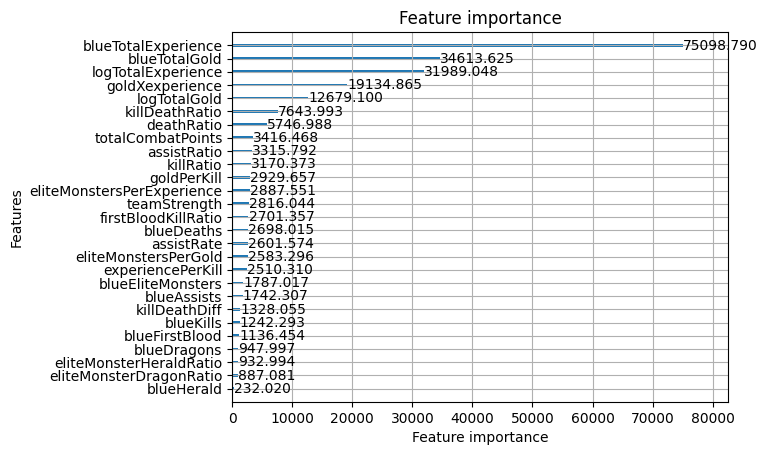

In [12]:
# 特徴量の重要度をプロット
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=30)
plt.show()

- testにy_test_pred結合

In [13]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_submit_cv_oputuna_FEselected_val{val_accuracy}.csv'

In [14]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_selected
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [15]:
check = pd.read_csv(output)

In [16]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
